# Determining the age of customers

The supermarket chain "Bread and Salt" is implementing a computer vision system for processing photos of customers. Photo capturing in the checkout area will help determine the age of customers in order to:

 - Analyze purchases and recommend products that may be of interest to customers in that age group
 - Monitor the cashiers' compliance with selling alcohol according to local regulations

The main task is to build a model that can estimate person's approximate age based on a photo. The model should achieve mean absolut error (MAE) value below 8.

The data consists of a dataset of people's photos along with their age labels.

## Preliminary Data Analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow import keras
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

SEED = 12345

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./225)
datagen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                           directory='/datasets/faces/final_files/',
                                           x_col='file_name',
                                           y_col='real_age',
                                           target_size=(224, 224),
                                           batch_size=32,
                                           class_mode='raw',
                                           seed=SEED)

Found 7591 validated image filenames.


In [3]:
features, target = next(datagen_flow)

In [4]:
print(features.shape)

(32, 224, 224, 3)


In [5]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [6]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


<Figure size 720x288 with 0 Axes>

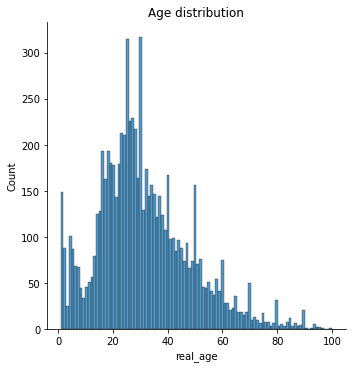

In [7]:
#The distribution of people's ages on the photos
plt.figure(figsize=(10,4))
sns.displot(labels['real_age'], kde=False, bins=100)
plt.title('Age distribution')
plt.show()

In [10]:
labels['real_age'].value_counts().head(20)

30    317
25    315
27    229
26    226
28    217
23    213
24    211
18    193
16    193
19    180
22    179
20    178
32    174
40    167
29    164
17    163
34    156
50    156
1     149
35    147
Name: real_age, dtype: int64

In [11]:
#Calculating the percentage of photos that feature people between 18 and 40 years old
(labels.query('(real_age > 18) & (real_age < 40)').count() / labels.shape[0]) * 100

file_name    50.309577
real_age     50.309577
dtype: float64

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

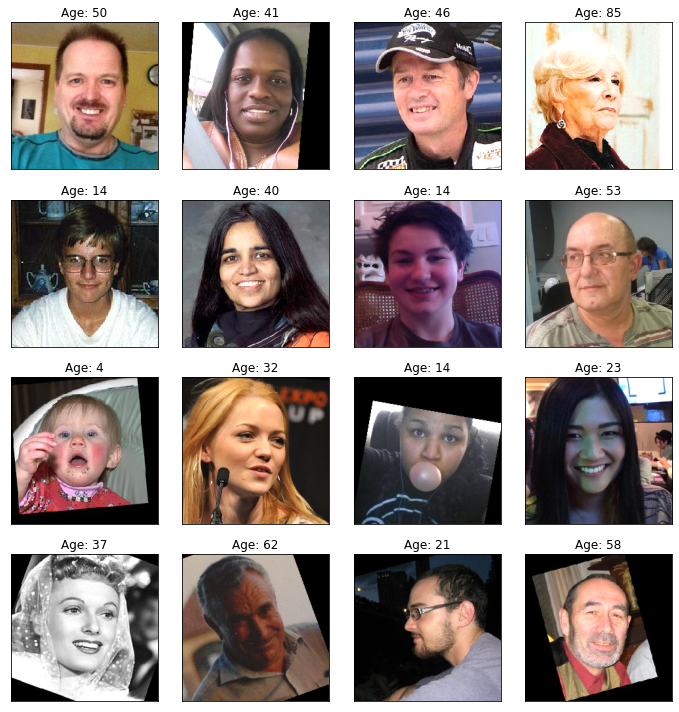

In [12]:
#Cheching the first 16 photos in the dataset and their age labels
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title('Age: {}'.format(target[i]))

The age distribution of customers is non-normal, with a concentration around 20-30 years old, and an average age of 31 years. Also, 50% of people in the photos are between 18 and 40 years old.

There are also peaks around value divisible by 5: 1, 25, 40, 50, 60, and 70 years. It can be assumed that the age labels were done manualy by a person who set the majority of values close to 5 so that the numbers appear round.

Nevertheless, half of the photos depict young people between 18 and 40 years old. Therefore, there is a probability that the model will perform better at determining the ages of younger individuals compared to older ones.

## Model training

The model training is performed through ResNet neural network.

```python
def load_train(path):

    df = pd.read_csv('/datasets/faces/labels.csv')

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=SEED)

    return train_gen_flow

def load_test(path):

    df = pd.read_csv('/datasets/faces/labels.csv')

    valid_datagen = ImageDataGenerator(
        rescale=1./255, 
        validation_split=0.2)

    validation_gen_flow = valid_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=SEED)

    return validation_gen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```
Train for 190 steps, validate for 48 steps
Epoch 1/10
190/190 - 65s - loss: 233.3626 - mae: 11.0086 - val_loss: 1010.4225 - val_mae: 26.9504
Epoch 2/10
190/190 - 50s - loss: 63.4607 - mae: 6.0387 - val_loss: 958.6639 - val_mae: 26.0689
Epoch 3/10
190/190 - 49s - loss: 33.4213 - mae: 4.4479 - val_loss: 200.6020 - val_mae: 10.8925
Epoch 4/10
190/190 - 50s - loss: 20.0745 - mae: 3.4684 - val_loss: 103.2700 - val_mae: 7.7401
Epoch 5/10
190/190 - 50s - loss: 14.3835 - mae: 2.9491 - val_loss: 80.2801 - val_mae: 7.0418
Epoch 6/10
190/190 - 51s - loss: 12.5176 - mae: 2.7785 - val_loss: 67.0430 - val_mae: 6.2125
Epoch 7/10
190/190 - 52s - loss: 11.8528 - mae: 2.6509 - val_loss: 113.5751 - val_mae: 8.6972
Epoch 8/10
190/190 - 52s - loss: 10.3597 - mae: 2.4859 - val_loss: 70.6327 - val_mae: 6.3195
Epoch 9/10
190/190 - 50s - loss: 9.6924 - mae: 2.3744 - val_loss: 73.3288 - val_mae: 6.3222
Epoch 10/10
190/190 - 52s - loss: 8.1193 - mae: 2.1446 - val_loss: 74.2777 - val_mae: 6.7219
48/48 - 8s - loss: 74.2777 - mae: 6.7219
Test MAE: 6.7219
```

## Analysis of the trained model

The Mean Absolute Error (MAE) on the test dataset achieved a result of 6.72, which is below the specified threshold of 8. This result indicates that the model estimates a person's age in a photograph with an error of 6.72 years.

From the training results, it is evident that the performance improved with each epoch, especially significantly after the third step.

## Conclusion

The goal of the project was to train a model to determine the age of supermarket's customers.

During the data analysis, it was found that the age distribution in the dataset is skewed to the left towards a younger age, and about half of the photos depict people between the ages of 18 and 40. Therefore, the model may tend to underestimate the age of customers. If the average age of the supermarket customers is higher than the average age in the dataset, it may be necessary to retrain the model using photos from different age groups.

The model was trained using the ResNet architecture, achieving a Mean Absolute Error (MAE) of 6.72 years.

Based on the obtained results, it is recommended to use this model to address the first task, which involves analyzing purchases and recommending products that may interest customers in specific age groups. To achieve this, potential customers can be categorized into age groups such as:

 - Children
 - Adolescents
 - Young adults
 - Middle-aged buyers
 - Elderly customers

However, regarding the second task, which involves monitoring cashiers' compliance when selling alcohol, considering the achieved MAE, the model may not perform well in reality for age verification purposes.

The trained model should address the supermarket's objectives because even with some error, the model will group people into similar age categories, resulting in product recommendations that align with what customers may need. However, to improve age estimation accuracy, it is advisable to augment the dataset with photos representing a more balanced age distribution.